# 导入数据

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 50)
# 导入包
import warnings  # 忽略错误提示
warnings.filterwarnings('ignore')  # 代码可以正常运行但是会提示警告，特别讨厌
warnings.simplefilter('ignore')  # 也是一种错误忽略

def data_load(path):
    data = pd.read_excel(path)
    return data
path = './datahouse/data_all.xlsx'  # 相对路径
data = data_load(path)
print('数据量：',data.shape)

数据量： (4619, 8)


In [2]:
data.head()

,岗位名称,岗位链接,公司名称,地点,工资,岗位职责,岗位要求,label
0,资深海外运营（slg）,https://uploadfiles.nowcoder.com/files/2019071...,三七互娱,未公布,¥薪资面议,\n\n1、负责slg手机游戏产品运营策略的制定、调整、组织实施和监控；\n\n2、监控并分...,\n\n1、本科及以上学历，3年以上游戏运营相关工作经验，对slg手游运营流程及全局把控比较...,运营
1,海外运营（请仔细阅读岗位要求）,https://images.nowcoder.com/files/20201119/999...,MindCoord,未公布,¥薪资面议,\n\n1、负责公司海外地区发行产品的对接，版本管理、优化与验收，以及上线前筹备准备工作；\...,\n\n* 本公司为创业公司，现招收希望转换赛道、有创业意愿的成员。仅有职位应聘想法，无创业...,运营
2,新媒体推广运营,https://images.nowcoder.com/images/20200723/30...,帆软软件有限公司,未公布,¥9K-16K,\n\n工作职责\n\n1.根据产品增长计划，参与产品推广策略的制定，全程跟进方案的落地执行...,\n\n任职资格\n\n1.本科院校，毕业1-3年内，专业不限，理工科优先；\n\n2.良好...,运营
3,产品运营,https://images.nowcoder.com/images/20200723/30...,帆软软件有限公司,未公布,¥10K-40K,\n\n1.功能运营方向：负责产品重要功能模块的上线运营，与产品部门配合，定位功能模块问题与...,\n\n1.重点本科及以上学历，毕业5年内，理工科专业背景；\n\n2.有toB软件运营/产...,运营
4,产品推广运营,https://images.nowcoder.com/images/20200723/30...,帆软软件有限公司,未公布,¥8K-16K,\n\n1、根据产品增长计划，参与产品推广策略的制定，全程跟进方案的落地执行，直接对推广结果...,\n\n1、重点本科院校，毕业3年内，专业不限，理工科优先；\n\n2、良好的文笔基础和审美...,运营


# 数据预处理

In [3]:
import re
import jieba
jieba.set_dictionary(".\dict.txt")
jieba.initialize()

def data_pre_process(Data):  # 数据预处理
    data = Data[:]
    data = data[['岗位名称','地点','工资','岗位职责','岗位要求','label']]  # 提取这几个字段
    data_drop = data.drop_duplicates(subset=['岗位名称','岗位职责','岗位要求'],keep='first',inplace =False)   # 按照岗位职责和岗位要求去除重复值
    data_drop = data_drop.dropna() # 去除空值
         
    data_drop['岗位职责_cut'] = data_drop['岗位职责'].apply(lambda x : x.replace('\n',''))
    data_drop['岗位职责_cut'] = data_drop['岗位职责_cut'].apply(lambda x : x.replace(' ',''))
    data_drop['岗位职责_cut'] = data_drop['岗位职责_cut'].apply(lambda x : re.sub('[0-9]','',x))
    data_drop['岗位职责_cut'] = data_drop['岗位职责_cut'].apply(lambda x : re.sub("[; ！•、，\\\/\'+．:（）...：‘，。’,“”、\#•*~(\t；-]",'',x))

    data_drop['岗位要求_cut'] = data_drop['岗位要求'].apply(lambda x : x.replace('\n',''))
    data_drop['岗位要求_cut'] = data_drop['岗位要求_cut'].apply(lambda x : x.replace(' ',''))
    data_drop['岗位要求_cut'] = data_drop['岗位要求_cut'].apply(lambda x : re.sub('[0-9]','',x))
    data_drop['岗位要求_cut'] = data_drop['岗位要求_cut'].apply(lambda x : re.sub("[; ！•、，\\\/\'+．:（）...：‘，。’,“”、\#•*~(\t；-]",'',x))

    # 分词
    jieba.load_userdict('interger.txt')  # 定义分隔词，保证数据词不被分开
    data_jieba = data_drop[:]
    data_jieba['岗位职责_cut'] = data_jieba['岗位职责_cut'].apply(lambda x:jieba.lcut(x))
    data_jieba['岗位要求_cut'] = data_jieba['岗位要求_cut'].apply(lambda x:jieba.lcut(x))

    # 去停用词
    stopwords = pd.read_csv('stoplist.txt',encoding='utf-8',sep='haha',header=None,engine='python')
    stopwords = ['要'] + list(stopwords.iloc[:,0])  # 手动添加停用词
    data_jieba['岗位职责_stop'] = data_jieba['岗位职责_cut'].apply(lambda x:[i for i in x if i not in stopwords])
    data_jieba['岗位职责_stop'] = data_jieba['岗位职责_stop'].apply(lambda x:' '.join(x))  # 转成字符串
    data_jieba['岗位要求_stop'] = data_jieba['岗位要求_cut'].apply(lambda x:[i for i in x if i not in stopwords])
    data_jieba['岗位要求_stop'] = data_jieba['岗位要求_stop'].apply(lambda x : ' '.join(x)) # 转成字符串
    data_jieba = data_jieba.reset_index(drop=True)
    return data_jieba
data_process = data_pre_process(data)

Building prefix dict from D:\python\商务智能\BI2\dict.txt ...
Loading model from cache C:\Users\赵轩\AppData\Local\Temp\jieba.uaa84715fb49bf8794905cb5cb7e555f5.cache
Loading model cost 0.562 seconds.
Prefix dict has been built successfully.


In [4]:
data_process.head(2)

,岗位名称,地点,工资,岗位职责,岗位要求,label,岗位职责_cut,岗位要求_cut,岗位职责_stop,岗位要求_stop
0,资深海外运营（slg）,未公布,¥薪资面议,\n\n1、负责slg手机游戏产品运营策略的制定、调整、组织实施和监控；\n\n2、监控并分...,\n\n1、本科及以上学历，3年以上游戏运营相关工作经验，对slg手游运营流程及全局把控比较...,运营,"[负责, slg, 手机游戏, 产品, 运营, 策略, 的, 制定, 调整, 组织, 实施,...","[本科, 及, 以上学历, 年, 以上, 游戏, 运营, 相关, 工作, 经验, 对, sl...",负责 slg 手机游戏 产品 运营 策略 调整 组织 实施 监控 监控 分析 产品 运营 数...,本科 游戏 运营 slg 手游 运营 流程 全局 游戏 经验丰富 手机游戏 产品 群体 市场...
1,海外运营（请仔细阅读岗位要求）,未公布,¥薪资面议,\n\n1、负责公司海外地区发行产品的对接，版本管理、优化与验收，以及上线前筹备准备工作；\...,\n\n* 本公司为创业公司，现招收希望转换赛道、有创业意愿的成员。仅有职位应聘想法，无创业...,运营,"[负责, 公司, 海外, 地区, 发行, 产品, 的, 对接, 版本, 管理, 优化, 与,...","[本, 公司, 为, 创业, 公司, 现, 招收, 希望, 转换, 赛道, 有, 创业, 意...",负责 公司 海外 地区 发行 产品 对接 版本 管理 优化 验收 上线 前 筹备 海外 市场...,公司 创业 公司 招收 转换 赛道 创业 意愿 职位 应聘 想法 创业 意愿 投递 干股 回...


# 抽取‘数据’岗位

In [5]:
shuju = data_process[data_process['label'] =='数据']

# “数据”岗位词云图

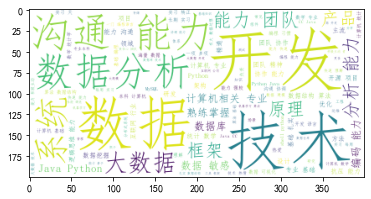

In [6]:
def Get_cloud(words):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.rcParams['axes.unicode_minus'] = False  
    font = r'C:\Windows\Fonts\simfang.ttf'
    wordcloud = WordCloud(font_path=font,
                         background_color='white')
    wordcloud.generate(str(words))
    plt.imshow(wordcloud)
    plt.show()
str_sum = shuju['岗位要求_stop'].sum()
Get_cloud(str_sum)  # 词云图

## 基于TF-IDF的“数据”岗位词云图

In [7]:
import jieba.analyse

tifidf_word = jieba.analyse.extract_tags(str(shuju['岗位要求_stop'].sum()), topK=50, withWeight=True, allowPOS=())

In [8]:
for i in range(10):
    print(tifidf_word[i])

('能力', 0.20451739196423394)
('Python', 0.11618681113631459)
('数据', 0.11403527838034762)
('大数据', 0.10977158843553647)
('开发', 0.09787360904054199)
('Java', 0.09587193925051725)
('专业', 0.09120900742168918)
('编程', 0.08654172910061264)
('数据分析', 0.07816045922207615)
('数据库', 0.07815695921352832)


In [9]:
str(tifidf_word).replace("'",'')   # 将keys的引号删除

'[(能力, 0.20451739196423394), (Python, 0.11618681113631459), (数据, 0.11403527838034762), (大数据, 0.10977158843553647), (开发, 0.09787360904054199), (Java, 0.09587193925051725), (专业, 0.09120900742168918), (编程, 0.08654172910061264), (数据分析, 0.07816045922207615), (数据库, 0.07815695921352832), (技术, 0.07682150134153831), (算法, 0.07591804875071072), (SQL, 0.07591346862587425), (本科, 0.074197062932972), (沟通, 0.07395758456506753), (计算机, 0.07282943119834004), (计算机相关, 0.07021104844740482), (实习, 0.07010254388284859), (扎实, 0.06518295397881943), (开源, 0.06509692961622991), (团队, 0.06446561391130669), (熟练掌握, 0.05987504739127389), (机器学习, 0.05595499800123126), (精通, 0.0551875126428763), (基础, 0.051263341042623506), (数据结构, 0.05013051355012969), (Linux, 0.04526296016660108), (语言, 0.04465104225966729), (分析, 0.0443307617098888), (编程语言, 0.044243217073189636), (数据仓库, 0.04383735512198372), (python, 0.04348095386082938), (数据处理, 0.04305962250064752), (框架, 0.042968448099928155), (Kafka, 0.040986145032749007), (数据挖掘, 0.0405561

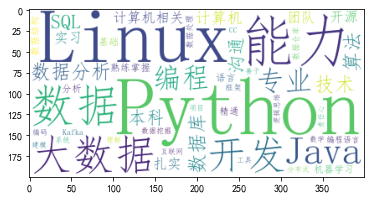

In [10]:
def Get_cloud(words):
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
    plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）
    font = r'C:\Windows\Fonts\simfang.ttf'
    wordcloud = WordCloud(font_path=font,
                         background_color='white')
    wordcloud.generate(str(words))
    plt.imshow(wordcloud)
    plt.show()
Get_cloud(str(tifidf_word).replace("'",''))  # 词云图

# TF-IDF

## CountVectorizer词频矩阵计算

In [11]:
sum_List = data_process.groupby('label')['岗位要求_stop'].sum()  # 根据标签将岗位要求合并

In [12]:
print(sum_List)

label
hr         毕业 在校学生 专业 积极主动 责任心 踏实 沟通 能力 抗压 能力 实习 连续 实习 每周...
产品专家       本科 产品设计 负责 App 产品 IoT 领域 产品设计 推荐 类产品 为佳 负责 一条 ...
产品助理       职位 以下几点 本科 国内外 知名 大学 院校 加分 英文 基础 大学 英语六级 同等 水平...
产品经理       全日制 本科 互联网 产品 企业 内部 管理 产品 卓越 放宽 两项 系统 ERP 财务 系...
产品运营       全日制 本科 产品 运营 互联网 金融公司 信用卡 中心 消费 金融公司 运营 背景 信贷 ...
人事         学生会 社团 善于 把握 品德 性格 吃苦 富 远见 锻炼 自我 能力专业 信息管理 人力 ...
人力         任职 RequirementsandQualifications 大专 人力资源 专业 三年...
前端工程师      重点 本科学历 毕业 年内 熟练掌握 Html CSS Websocket 开发 jQuer...
后台开发工程师    熟练掌握 CC Python 一门 语言 扎实 数据结构 算法 功底 开源 组件 MySQL...
后端工程师      公司 创业 公司 招收 转换 赛道 创业 意愿 职位 应聘 想法 创业 意愿 投递 干股 回...
售前工程师      重点 大学 本科学历 理工科 专业 背景 毕业 年内 企业 信息化 软件 常见 功能 场景 ...
大数据工程师     任职 资格 重点 本科毕业 年内 理工科 专业 背景 Java 基础 SpringbootG...
安全工程师      负责 企业 系统 网络安全 规划 重点 负责 OAIDC 云 方向 负责 指导 线 系统 网...
实施工程师      重点 院校 本科 毕业生 理工科 专业 背景 软件 专业 软件 背景 沟通 能力 人际交往 ...
市场         大学本科 互联网 广告投放 形式 主流 广告 如广点 通 UC 爱奇艺 百度 微信 投放 流...
开发工程师      本科学历 毕业 年内 计算机 统计 数学 专业 熟练掌握 SQL MySQL Postgre...
推广         海外 产品 投

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

stopwords = pd.read_csv('stoplist.txt',encoding='utf-8',sep='haha',header=None,engine='python')
count_vec = CountVectorizer(max_df=5000,min_df=2,max_features=100)
sparse_result_count = count_vec.fit_transform(sum_List)
# 输出稀疏矩阵
# print(sparse_result_count)
# 输出关键词
print(count_vec.get_feature_names())
# 输出关键词编号
print(count_vec.vocabulary_)

['android', 'cc', 'go', 'java', 'linux', 'mysql', 'python', 'sql', 'web', '一门', '专业', '专业本科', '主流', '互联网', '产品', '代码', '优化', '公司', '分布式', '分析', '前端', '办公', '功底', '协作', '协调', '原理', '善于', '团队', '基础', '多线程', '大数据', '实习', '工具', '常见', '并发', '开发', '开源', '快速', '思维', '性能', '意识', '扎实', '技术', '抗压', '操作系统', '敏感', '数学', '数据', '数据分析', '数据处理', '数据库', '数据结构', '方法', '服务', '本科', '机器学习', '架构', '框架', '每周', '沟通', '流程', '测试', '游戏', '热情', '热爱', '熟练掌握', '独立', '环境', '理解', '知识', '研发', '积极主动', '算法', '管理', '精神', '精通', '系统', '经历', '编码', '编程', '编程语言', '网络', '背景', '能力', '自我', '行业', '解决', '计算机', '计算机相关', '设计', '语言', '负责', '责任心', '软件', '运营', '逻辑', '逻辑思维', '项目', '领域', '驱动']
{'专业': 10, '积极主动': 71, '责任心': 92, '沟通': 59, '能力': 83, '抗压': 43, '实习': 31, '每周': 58, '本科': 54, '办公': 21, '软件': 93, '领域': 98, '逻辑思维': 96, '团队': 27, '协作': 23, '功底': 22, '工具': 32, '善于': 26, '协调': 24, '快速': 37, '环境': 67, '分析': 19, '计算机': 87, '精神': 74, '项目': 97, '服务': 53, '意识': 40, '热爱': 64, '自我': 84, '公司': 17, '热情': 63, '互联网': 13, '产品': 14, '技术': 42, '行

使用TfidfVectorizer提取词频矩阵

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 建立TfidfVectorizer模型
tfidf_vec = TfidfVectorizer(min_df=5,max_df=5000,max_features=200)
# 计算tfidf矩阵
sparse_result_tfidf = tfidf_vec.fit_transform(sum_List)
# 输出稀疏矩阵
print(sparse_result_tfidf[:,3])
# 输出关键词
print(tfidf_vec.get_feature_names())
# 输出关键词编号
print(tfidf_vec.vocabulary_)

  (7, 0)	0.07041727424428985
  (9, 0)	0.03267891589039315
  (11, 0)	0.037864112800857955
  (13, 0)	0.22955975450220872
  (15, 0)	0.02607859842861075
  (17, 0)	0.03157433611071929
  (25, 0)	0.01487900334623874
  (26, 0)	0.008539414758089356
  (29, 0)	0.02451603727720365
  (30, 0)	0.01670070776268125
  (32, 0)	0.003612516249555401
  (34, 0)	0.0010374854127877724
  (38, 0)	0.02019351034007727
['android', 'cc', 'css', 'es', 'go', 'hive', 'html', 'ios', 'java', 'js', 'kafka', 'linux', 'mysql', 'php', 'python', 'react', 'redis', 'shell', 'sql', 'vue', 'web', '一年', '一门', '专业', '专业本科', '严谨', '主动', '主流', '习惯', '互联网', '产品', '代码', '企业', '优化', '体系', '体验', '公司', '关注', '兴趣', '分布式', '分布式系统', '分析', '分项', '创新', '前端', '办公', '功底', '协作', '协议', '协调', '压力', '原理', '发展', '善于', '喜欢', '团队', '场景', '培训', '基础', '基础知识', '多线程', '大数据', '大规模', '好奇心', '媒体', '存储', '实习', '实践', '客户', '工具', '工程', '市场', '常见', '并发', '广告', '建模', '开发', '开源', '快速', '思维', '思考', '性能', '意识', '扎实', '执行', '执行力', '技术', '抗压', '挑战', '推动', '推荐', '提供', '

# 相似性推荐

## 基于岗位职责的相似性推荐

In [15]:
a1 = data_process[data_process['label']=='数据'][1:2][['岗位名称','岗位职责_stop']]
gangweizhize = data_process[data_process['label']=='数据'][1:2]['岗位职责_stop']
a1

,岗位名称,岗位职责_stop
936,数据研发工程师-【电商生态】,负责 手电 商 数据仓库 构建 垂直 数据 集市 负责 手电 商新 产品 数据 统计 报表 ...


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer

# 建立TfidfVectorizer模型
tfidf_vec = TfidfVectorizer(min_df=1,max_df=5000,max_features=200)
# 计算tfidf矩阵
sparse_result_tfidf = tfidf_vec.fit_transform(gangweizhize)
# 输出稀疏矩阵
print(sparse_result_tfidf)
# 输出关键词
print(tfidf_vec.get_feature_names())
# 输出关键词编号
print(tfidf_vec.vocabulary_)

  (0, 4)	0.11785113019775793
  (0, 3)	0.11785113019775793
  (0, 17)	0.11785113019775793
  (0, 28)	0.11785113019775793
  (0, 31)	0.11785113019775793
  (0, 9)	0.11785113019775793
  (0, 22)	0.11785113019775793
  (0, 2)	0.11785113019775793
  (0, 19)	0.11785113019775793
  (0, 12)	0.11785113019775793
  (0, 10)	0.11785113019775793
  (0, 21)	0.11785113019775793
  (0, 13)	0.11785113019775793
  (0, 20)	0.11785113019775793
  (0, 27)	0.11785113019775793
  (0, 14)	0.11785113019775793
  (0, 11)	0.11785113019775793
  (0, 6)	0.11785113019775793
  (0, 5)	0.11785113019775793
  (0, 15)	0.11785113019775793
  (0, 29)	0.11785113019775793
  (0, 23)	0.11785113019775793
  (0, 0)	0.11785113019775793
  (0, 18)	0.11785113019775793
  (0, 30)	0.11785113019775793
  (0, 1)	0.11785113019775793
  (0, 7)	0.11785113019775793
  (0, 33)	0.11785113019775793
  (0, 24)	0.5892556509887896
  (0, 8)	0.23570226039551587
  (0, 26)	0.11785113019775793
  (0, 25)	0.11785113019775793
  (0, 16)	0.23570226039551587
  (0, 32)	0.353553390

In [17]:
# 文本特征提取模块，CountVectorizer词频统计，TfidfTransformer把词频结果转化为TF-IDF类
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer   
countVectorizer = CountVectorizer()
data_tr = countVectorizer.fit_transform(data_process['岗位职责_stop'])  # 装换为权值向量
# 获得训练集对象的TF-IDF权值
X_tr = TfidfTransformer().fit_transform(data_tr.toarray()).toarray()

In [18]:
X_tr.shape

(3849, 8168)

In [19]:
# 计算两个向量之间的余弦相似度
import numpy as np
def cos_sin(vector_a , vector_b):
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

a_dict = {}
n = 0
k = 2
for i in range(len(X_tr)):
    if i != k:
        a_dict[n] = cos_sin(X_tr[k],X_tr[i])
        n += 1
L = sorted(a_dict.items(),key=lambda item:item[1],reverse=True)
L = L[:5]
print(L)

[(3, 1.0), (665, 1.0), (666, 1.0), (3717, 1.0), (3718, 1.0)]


In [20]:
L = sorted(a_dict.items(),key=lambda item:item[1],reverse=True)  # 排序
L[:10]

[(3, 1.0),
 (665, 1.0),
 (666, 1.0),
 (3717, 1.0),
 (3718, 1.0),
 (183, 0.6812860155598801),
 (860, 0.6812860155598801),
 (254, 0.6711570949130182),
 (272, 0.6656028304175245),
 (10, 0.6592087331311531)]

In [21]:
for i in range(3):   # 查看相似性最高的5个岗位
    print(L[i][0])
    a = int(L[i][0])
    print(data_process.iloc[a])

3
岗位名称                                                      产品运营
地点                                                         未公布
工资                                                    ¥10K-40K
岗位职责         \n\n1.功能运营方向：负责产品重要功能模块的上线运营，与产品部门配合，定位功能模块问题与...
岗位要求         \n\n1.重点本科及以上学历，毕业5年内，理工科专业背景；\n\n2.有toB软件运营/产...
label                                                       运营
岗位职责_cut     [功能, 运营, 方向, 负责, 产品, 重要, 功能模块, 的, 上线, 运营, 与, 产...
岗位要求_cut     [重点, 本科, 及, 以上学历, 毕业, 年内, 理工科, 专业, 背景, 有, toB,...
岗位职责_stop    功能 运营 方向 负责 产品 功能模块 上线 运营 产品 部门 配合 定位 功能模块 提高 ...
岗位要求_stop    重点 本科 毕业 年内 理工科 专业 背景 toB 软件 运营 产品 经理 实习 toB 项...
Name: 3, dtype: object
665
岗位名称                                                      产品运营
地点                                                          南京
工资                                                       ¥薪酬面议
岗位职责         \n\n1.功能运营方向：负责产品重要功能模块的上线运营，与产品部门配合，定位功能模块问题与...
岗位要求         \n1、重点院校本科及以上，理工科专业背景； 2、做事有激情，有强烈的主动性，强大的逻辑思维...
label                     

In [22]:
data_process.iloc[1300]

岗位名称                                             【急招】算法工程师-需求大
地点                                                         未公布
工资                                                    ¥20K-40K
岗位职责         \n\n岗位描述：\n\n1、熟练掌握各种主流机器学习算法的基础上，分析不同的客户业务需求，...
岗位要求         \n\n：\n\n1、拥有计算机科学、统计或相关学科学位，或在大数据领域有工作经验；\n\n...
label                                                       数据
岗位职责_cut     [岗位, 描述, 熟练掌握, 各种, 主流, 机器学习, 算法, 的, 基础, 上, 分析,...
岗位要求_cut     [拥有, 计算机科学, 统计, 或, 相关, 学科, 学位, 或, 在, 大数据, 领域, ...
岗位职责_stop    描述 熟练掌握 主流 机器学习 算法 基础 分析 客户 场景 寻找 构建 行业 解决方案 业...
岗位要求_stop    计算机科学 统计 学科 学位 大数据 领域 机器学习 领域 研发 项目 落地 沟通 能力 团...
Name: 1300, dtype: object

### 集成

In [23]:
import numpy as np
base_duty = data_process['岗位职责_stop']

from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
# 建立TfidfVectorizer模型
tfidf_vec = TfidfVectorizer(min_df=1,max_df=5000,max_features=200)
# 计算tfidf矩阵
sparse_result_tfidf = tfidf_vec.fit_transform(base_duty)

# 文本特征提取模块，CountVectorizer词频统计，TfidfTransformer把词频结果转化为TF-IDF类
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer   
countVectorizer = CountVectorizer()
data_tr = countVectorizer.fit_transform(data_process['岗位职责_stop'])  # 装换为权值向量
# 获得训练集对象的TF-IDF权值
X_tr = TfidfTransformer().fit_transform(data_tr.toarray()).toarray()

# 计算两个向量之间的余弦相似度
def cos_sin(vector_a , vector_b):
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

In [24]:
while True:
    n = input('请输入你喜欢的一类岗位：')
    print('---------------------------------------------------------------------------')
    data = data_process[data_process['岗位名称'].str.contains(n)][['岗位名称','地点','工资','岗位职责','岗位要求']]
    if len(data)>=1:
        print(data)
        data.to_excel('您喜欢的岗位数据.xlsx')
        print('---------------------------------------------------------------------------')
        m = input('请输入你想了解的岗位序号：')
        print(data_process.loc[int(m),['岗位名称','地点','工资','岗位职责','岗位要求']])
        data_process.loc[int(m),['岗位名称','地点','工资','岗位职责','岗位要求']].to_excel('您想了解的岗位数据.xlsx')
        print('---------------------------------------------------------------------------')
        k = input('是否需要推荐岗位职责相关工作？请输入yes或者no：')
        a_dict = {}
        if k =='yes':
            n = 0
            for i in range(len(X_tr)):
                if i != m:
                    a_dict[n] = cos_sin(X_tr[int(m)],X_tr[i])
                    n += 1
            L = sorted(a_dict.items(),key=lambda item:item[1],reverse=True)
            data_frame = pd.DataFrame(columns=['岗位名称','地点','工资','岗位职责','岗位要求','相似度'])
            for i in range(5):
                print(L[i][0],end='\t')
                a = int(L[i][0])
                print(data_process.iloc[a][['岗位名称','地点','工资','岗位职责','岗位要求']])
                data_frame.loc[i] = data_process.iloc[a][['岗位名称','地点','工资','岗位职责','岗位要求']]
                data_frame.loc[i][5] = L[i][1]

                print('岗位相似度：',L[i][1])
            data_frame.to_excel('相似岗位推荐.xlsx')
        else:
            pass
        print('---------------------------------------------------------------------------')
        o = input('是否继续查询，请输入yes或者no：')
        if o == 'yes':
            continue
        else:
            break
    else:
        print('---------------------------------------------------------------------------')
        print('暂时无法查询您输入的工作岗位，请重新输入！')
        continue

请输入你喜欢的一类岗位：数据挖掘
---------------------------------------------------------------------------
                     岗位名称        地点          工资  \
950       【急招】数据挖掘工程师-需求大       未公布    ¥18K-35K   
960               数据挖掘工程师       未公布    ¥10K-25K   
1027           数据挖掘工程师—深圳       未公布    ¥25K-60K   
1029              数据挖掘及分析       未公布    ¥11K-20K   
1035              数据挖掘工程师       未公布    ¥10K-25K   
...                   ...       ...         ...   
3267         数据挖掘算法工程师-电商  北京,上海,杭州       ¥薪资面议   
3368      安全数据挖掘工程师-大数据方向       未公布  ¥180K-300K   
3369            安全数据挖掘工程师       未公布  ¥180K-300K   
3370  高级服务器开发工程师-安全数据挖掘方向       未公布  ¥180K-300K   
3839      数据挖掘工程师 -【电商风控】        北京         51K   

                                                   岗位职责  \
950   \n\n1、从数据中探寻并发现业务规律，并主动与客户沟通，提炼场景，为算法工程师提供业务经验...   
960   \n\n1.基于人体生理健康、医疗、活动数据的研究探索\n\n2.基于智能穿戴或传感器数据的...   
1027  \n\n1、负责头条系产品的数据挖掘、分析以及策略工作；\n\n2、深入理解头条系的某一个业...   
1029  \n\n工作内容：\n\n1.负责C端APP用户行为分析及画像；\n\n2.参与知识图谱搭建...   

## 基于能力要求的相似性推荐

In [25]:
base_duty = data_process['岗位要求_stop']

from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
# 建立TfidfVectorizer模型
tfidf_vec = TfidfVectorizer(min_df=1,max_df=5000,max_features=200)
# 计算tfidf矩阵
sparse_result_tfidf = tfidf_vec.fit_transform(base_duty)

# 文本特征提取模块，CountVectorizer词频统计，TfidfTransformer把词频结果转化为TF-IDF类
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer   
countVectorizer = CountVectorizer()
data_tr = countVectorizer.fit_transform(data_process['岗位要求_stop'])  # 装换为权值向量
# 获得训练集对象的TF-IDF权值
X_tr = TfidfTransformer().fit_transform(data_tr.toarray()).toarray()

# 计算两个向量之间的余弦相似度
def cos_sin(vector_a , vector_b):
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

In [26]:
while True:
    n = input('请输入你喜欢的一类岗位：')
    print('---------------------------------------------------------------------------')
    data = data_process[data_process['岗位名称'].str.contains(n)][['岗位名称','地点','工资','岗位职责','岗位要求']]
    if len(data)>=1:
        print(data)
        data.to_excel('您喜欢的岗位数据.xlsx')
        print('---------------------------------------------------------------------------')
        m = input('请输入你想了解的岗位序号：')
        print(data_process.loc[int(m),['岗位名称','地点','工资','岗位职责','岗位要求']])
        data_process.loc[int(m),['岗位名称','地点','工资','岗位职责','岗位要求']].to_excel('您想了解的岗位数据.xlsx')
        print('---------------------------------------------------------------------------')
        k = input('是否需要推荐岗位职责相关工作？请输入yes或者no：')
        a_dict = {}
        if k =='yes':
            n = 0
            for i in X_tr:
                a_dict[n] = cos_sin(X_tr[int(m)],i)
                n += 1
            L = sorted(a_dict.items(),key=lambda item:item[1],reverse=True)
            data_frame = pd.DataFrame(columns=['岗位名称','地点','工资','岗位职责','岗位要求','相似度'])
            for i in range(5):
                print(L[i][0],end='\t')
                a = int(L[i][0])
                print(data_process.iloc[a][['岗位名称','地点','工资','岗位职责','岗位要求']])
                data_frame.loc[i] = data_process.iloc[a][['岗位名称','地点','工资','岗位职责','岗位要求']]
                data_frame.loc[i][5] = L[i][1]

                print('岗位相似度：',L[i][1])
            data_frame.to_excel('相似岗位推荐.xlsx')
        else:
            pass
        print('---------------------------------------------------------------------------')
        o = input('是否继续查询，请输入yes或者no：')
        if o == 'yes':
            continue
        else:
            break
    else:
        print('---------------------------------------------------------------------------')
        print('暂时无法查询您输入的工作岗位，请重新输入！')
        continue

请输入你喜欢的一类岗位：大数据工程师
---------------------------------------------------------------------------
                         岗位名称                                             地点  \
146   阿里云日志大数据（SLS）增长运营大数据工程师                                            未公布   
962               大数据工程师-实时数仓                                            未公布   
964           大数据工程师-实时数据仓库方向                                            未公布   
989                    大数据工程师                                            未公布   
1098                   大数据工程师                                            未公布   
1101                   大数据工程师                                            未公布   
1155                 高级大数据工程师                                            未公布   
1186                 大数据工程师社招                                            未公布   
1188               大数据工程师-需求大                                            未公布   
1193                 字节大数据工程师                                            未公布   
1259                   大数